# Simple GP lnlikelihood

In [2]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve
import time
import argparse

In [ ]:

parser = argparse.ArgumentParser(prog="least_sqaures_cpu.py", description="Demo of fitting a line with least squares.")
parser.add_argument("--Nsamples", type=int, default=5000)
args = parser.parse_args()

np.random.seed(123456)

#First, build the "true" dataset with N=50 datapoints from a line model y=mx+b.
true_m, true_b = 0.5, -0.25
N = args.Nsamples

In [147]:
%%time
np.random.seed(123456)

#First, build the "true" dataset with N=50 datapoints from a line model y=mx+b.
true_m, true_b = 0.5, -0.25
true_theta = np.array([true_m, true_b])
N = 10000
x = np.linspace(-5, 5, N)
y = true_m * x + true_b

#Introduce some noise with both measurement uncertainties
#   and non-trivial correlated errors.
yerr = 0.1 + 0.4 * np.random.rand(N)
yerr_hom = 0.4*np.ones(N)
hom_cov = np.diag(yerr_hom ** 2)
iid_cov = np.diag(yerr ** 2)
true_cov = 0.5 * np.exp(-0.5 * (x[:, None]-x[None, :])**2 / 1.3**2) + np.diag(yerr ** 2)

%%time
## This step draws the fake data from a MVN
## BUT it's TOO SLOW.  Do the hacky thing below instead.
#y = np.random.multivariate_normal(y, true_cov)
#np.save('y_fake.npy', y)
#y = np.load('y_fake.npy')

y = y + yerr*np.random.randn(N)
coeffs = np.load('correlation_coeffs.npy')
y = y + correlated_noise(x) # much faster!

#Linear algebra
A = np.vander(x, 2)
C = true_cov
guess_theta = np.array([true_m*1.1, true_b*0.9])
#model = np.dot(A, guess_theta)
model = np.dot(A, true_theta)

t0 = time.time()
factor, flag = cho_factor(C)
logdet = np.sum(2 * np.log((np.diag(factor))))
R = y - model
lnprob = -0.5 * (np.dot(R, cho_solve((factor, flag), R)) + logdet)
t1 = time.time()

net_time = t1-t0
print(" lnprob: {:.2f} \n time: {}".format(lnprob, net_time))

CPU times: user 335 ms, sys: 475 ms, total: 810 ms
Wall time: 810 ms


## Speedup the multivariate normal nonsense

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [131]:
coeffs = np.polyfit(x, R, 10)

In [132]:
correlated_noise = np.poly1d(coeffs)

In [135]:
np.save('correlation_coeffs.npy' , coeffs)

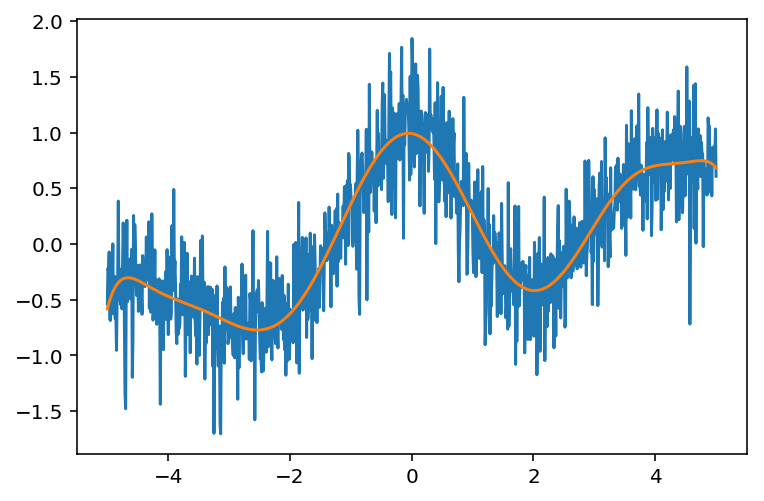

In [133]:
plt.plot(x, R)
plt.plot(x, correlated_noise(x));